In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta
from datasets import load_dataset
import matplotlib.pyplot as plt
import math
import sys
import os

sys.path.append("../src")
from llms import MyOpenAIModel, image_to_base64
import PIL.Image

In [2]:
ds = load_dataset("BrachioLab/mcmed-cardiac")
train_data = ds['train']
train_data

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Dataset({
    features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size', 'MRN', 'CSN', 'Visit_no', 'Visits', 'Age', 'Gender', 'Race', 'Ethnicity', 'Means_of_arrival', 'Triage_Temp', 'Triage_HR', 'Triage_RR', 'Triage_SpO2', 'Triage_SBP', 'Triage_DBP', 'Triage_acuity', 'CC', 'ED_dispo', 'Hours_to_next_visit', 'Dispo_class_next_visit', 'ED_LOS', 'Hosp_LOS', 'DC_dispo', 'Payor_class', 'Admit_service', 'Dx_ICD9', 'Dx_ICD10', 'Dx_name', 'Arrival_time', 'Roomed_time', 'Dispo_time', 'Admit_time', 'Departure_time'],
    num_rows: 400
})

In [3]:
example = train_data[201]
print(example['label'], example['alarm'])

True 2271-07-22 07:53:28


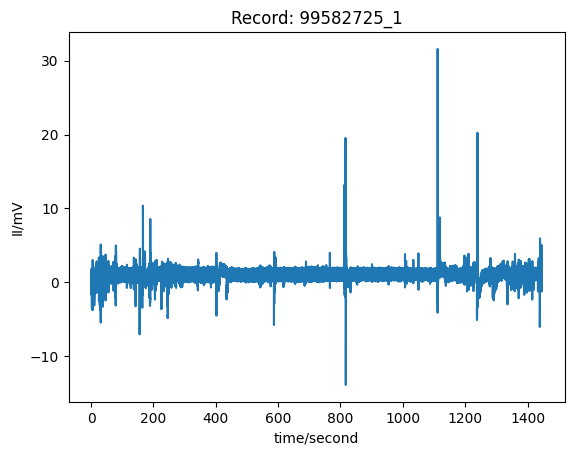

In [4]:
record_keys = ['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size']
record_dict = {k: v for k, v in example.items() if k in record_keys}
record_dict['p_signal'] = np.array(record_dict['p_signal']) 
record = wfdb.Record(**record_dict)

wfdb.plot_wfdb(record=record)

 - Potential Task: given 5 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - *Shorter Task:* given 2 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - **Chosen Task:** given 2 minutes of ECG data at 500 Hz (in a graph image), predict whether this patient gets cardiac arrest in the next 5 minutes

Also each is given patient age, gender, race and ICU visit reason

Pipeline:
1. get the alarm time
2. subtract r = 1- 300 sec from it
3. this is your new cutoff time
4. then take the preceding 120 seconds from that

in terms of p_signal data:
1. get new cutoff time data = orig_alarm_time_data_index - r * fs
2. get new start time data = new_cutoff_time_data_index - 120 * fs
   

In [5]:
import random
import copy

def extract_segment_before_alarm(record, alarm_dt=None, duration_sec=120, max_predict_window_sec=300):
    fs = record.fs
    start_dt = datetime.combine(record.base_date, record.base_time)
    total_duration_sec = record.sig_len / fs
    end_dt = start_dt + timedelta(seconds=total_duration_sec)

    # pick a random cutoff time
    predict_window_sec = random.randint(1, max_predict_window_sec)
    print(predict_window_sec)
        
    if alarm_dt is not None:
        cutoff_dt = alarm_dt - timedelta(seconds=predict_window_sec)
        new_start_dt = cutoff_dt - timedelta(seconds=duration_sec)
        print(start_dt, end_dt)
        print(alarm_dt)
        print(new_start_dt, cutoff_dt)
        assert new_start_dt >= start_dt and cutoff_dt > new_start_dt
    else:
        new_start_dt = start_dt
        cutoff_dt = new_start_dt + timedelta(seconds=duration_sec)

    # get new p_signal
    # print(start_dt, end_dt)
    # print(alarm_dt)
    # print(new_start_dt, cutoff_dt)
    print((new_start_dt - start_dt).total_seconds())
    start_idx = int((new_start_dt - start_dt).total_seconds()) * fs
    cutoff_idx = math.ceil((cutoff_dt - start_dt).total_seconds()) * fs
    # print(start_idx, cutoff_idx)    
    segment = record.p_signal[start_idx:cutoff_idx]

    # Create new record object with the same metadata
    segment_record = copy.deepcopy(record)
    segment_record.p_signal = segment
    segment_record.base_date = new_start_dt.date()
    segment_record.base_time = new_start_dt.time()
    
    return segment_record


In [11]:
duration_sec = 120
max_predict_window_sec = 300

segment_record = extract_segment_before_alarm(record, example['alarm'], duration_sec, max_predict_window_sec)

8
2271-07-22 07:49:50.331001 2271-07-22 08:13:56.747001
2271-07-22 07:53:28
2271-07-22 07:51:20 2271-07-22 07:53:20
89.668999
44500 105000


In [12]:
segment_record.__dict__

{'record_name': '99582725_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 723208,
 'base_time': datetime.time(7, 51, 20),
 'base_date': datetime.date(2271, 7, 22),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[0.30989525],
        [0.32031774],
        [0.32518156],
        ...,
        [0.86020251],
        [0.87965782],
        [0.87479399]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99582725_1.dat'],
 'fmt': ['16'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [1439.1959798994976],
 'baseline': [-12719],
 'units': ['mV'],
 'adc_res': [16],
 'adc_zero': [0],
 'init_value': [-12906],
 'checksum': [62175],
 'block_size': [0]}

In [13]:
wfdb.plot_wfdb(segment_record, return_fig=True)
record_name = segment_record.__dict__['record_name']
plt.savefig(f'_dump/cardiac/{record_name}.png', dpi=200, bbox_inches='tight')
plt.close()

In [23]:
with open("../API_KEY.txt", "r") as file:
    api_key = file.read()
    client = OpenAI(api_key=api_key)
    
llm = MyOpenAIModel(model_name="gpt-4o", api_key=api_key)

In [28]:
# my_image_path = "../src/prompts/massmaps_relevance_few_shot_examples.0.Omega0.1041.sigma0.9396.png"
my_image_path = f"_dump/cardiac/{record_name}.png"
image = PIL.Image.open(my_image_path)

# sanity check
llm(["What's your name?", 
     ("tell me what you think of this image", image)])

['I’m called ChatGPT. How can I assist you today?',
 'This image is a graph showing a time series plot with time on the x-axis (in seconds) and amplitude on the y-axis (in millivolts, mV). It appears to represent some form of electrical activity or signal over time, possibly an ECG or similar physiological measurement. The data shows fluctuations with several spikes, indicating significant changes in the signal amplitude at specific times. The overall pattern is consistent until around the 50-second mark, where more noticeable variations occur.']

In [30]:
vanilla_baseline = """In addition to the answer, please provide a single paragraph under 3-5 sentences explaining why you gave the answer you did."""

cot_baseline = """To come up with the correct answer, think step-by-step. You should walk through each step in your reasoning process and explain how you arrived at the answer. Describe your step-by-step reasoning in a single paragraph under 3-5 sentences. This paragraph will serve as the explanation for your answer."""

socratic_baseline = """To come up with the correct answer, have a conversation with yourself. Pinpoint what you need to know, ask critical questions, and constantly challenge your understanding of the field. Describe this question-and-answer journey in a single paragraph under 3-5 sentences. This paragraph will serve as the explanation for your answer."""

least_to_most_baseline = """To come up with the correct answer, determine all of the subquestions you must answer. Start with the easiest subquestion, answer it, and then use that subquestion and answer to tackle the next subquestion. Describe your subquestion decomposition and answers in a single paragraph under 3-5 sentences. This paragraph will serve as the explanation for your answer."""


In [37]:
import humanize

new_start_dt = datetime.combine(segment_record.base_date, segment_record.base_time)
cutoff_dt = new_start_dt + timedelta(seconds=duration_sec)

duration_str = humanize.precisedelta(duration_sec)
pred_window_str = humanize.precisedelta(max_predict_window_sec)

ecg_data = segment_record.p_signal.flatten().tolist()
ecg_data_str = ", ".join(f"{v:.5f}" for v in ecg_data)
ecg_data_str = "[" + ecg_data_str + "]"

duration_str = humanize.precisedelta(duration_sec)
pred_window_str = humanize.precisedelta(max_predict_window_sec)
patient_info_str = f"The patient is age {example['Age']}, gender {example['Gender']}, race {example['Race']}, and was admitted to the ICU for {example['Dx_name']}."


cardiac_prompt = """You are a medical expert specializing in cardiac arrest prediction. 
You will be given some basic background information about an ICU patient, including their age, gender, race, and primary reason for ICU admittance. You will also be provided with time-series Electrocardiogram (ECG) data plotted in a graph from the first {} of an ECG monitoring period during the patient's ICU stay. Each entry consists of a measurement value at that timestamp. The samples are taken at {} Hz, so that each consecutive measurement value is taken {} milliseconds apart. 

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {}. Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
[BASELINE_PROMPT] 
Focus on the features of the data you used to make your yes or no binary classification. 
Your judgment will be reviewed alongside those of other medical experts, so please provide your best assessment without concern for perfection.

Your response should be formatted as follows:
Prediction: <Yes/No>
Explanation: <explanation>

Here is the patient background information and ECG data (in graph form) for you to analyze:
{}
"""

cardiac_prompt = cardiac_prompt.replace("[BASELINE_PROMPT]", vanilla_baseline)
# cardiac_prompt = cardiac_prompt.format(duration_str, segment_record.fs, 1 / segment_record.fs, pred_window_str, patient_info_str, ecg_data_str)
cardiac_prompt = cardiac_prompt.format(duration_str, segment_record.fs, 1 / segment_record.fs, pred_window_str, patient_info_str)

print(cardiac_prompt)

You are a medical expert specializing in cardiac arrest prediction. 
You will be given some basic background information about an ICU patient, including their age, gender, race, and primary reason for ICU admittance. You will also be provided with time-series Electrocardiogram (ECG) data plotted in a graph from the first 2 minutes of an ECG monitoring period during the patient's ICU stay. Each entry consists of a measurement value at that timestamp. The samples are taken at 500 Hz, so that each consecutive measurement value is taken 0.002 milliseconds apart. 

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next 5 minutes. Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
In addition to the answer, please provide a single paragraph under 3-5 sentences explaining why you gave the answer you did. 
Focus on the features of the data you used to make your yes or no binary classification

In [38]:
len(cardiac_prompt)

1456

In [39]:
response = llm((cardiac_prompt, image))
print(response)

Prediction: Yes

Explanation: The ECG data shows significant irregularities, including pronounced spikes and troughs, which could indicate possible arrhythmias. The variability and abrupt deviations from the baseline suggest instability in the cardiac rhythm, which are potential precursors to cardiac arrest. Given the trauma from the motor vehicle collision, the patient might be at a higher risk for cardiac complications, warranting close monitoring.


----

 - Task: given 5 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - **Shorter Task:** given 2 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes

Also each is given patient age, gender and visit reason

In [11]:
sorted(durations)

[datetime.timedelta(microseconds=873001),
 datetime.timedelta(seconds=3, microseconds=595999),
 datetime.timedelta(seconds=4, microseconds=202000),
 datetime.timedelta(seconds=6, microseconds=665000),
 datetime.timedelta(seconds=12, microseconds=87000),
 datetime.timedelta(seconds=13, microseconds=613999),
 datetime.timedelta(seconds=34, microseconds=429999),
 datetime.timedelta(seconds=46, microseconds=133001),
 datetime.timedelta(seconds=52, microseconds=988000),
 datetime.timedelta(seconds=54, microseconds=311999),
 datetime.timedelta(seconds=59, microseconds=96000),
 datetime.timedelta(seconds=59, microseconds=988001),
 datetime.timedelta(seconds=59, microseconds=991000),
 datetime.timedelta(seconds=60, microseconds=666000),
 datetime.timedelta(seconds=66, microseconds=270000),
 datetime.timedelta(seconds=68, microseconds=153001),
 datetime.timedelta(seconds=91, microseconds=289000),
 datetime.timedelta(seconds=95, microseconds=982000),
 datetime.timedelta(seconds=108, microseconds

In [29]:
def get_start_end_times(record_dict):
    start_dt = datetime.combine(datetime.today(), record_dict['base_time'])
    duration_sec = record_dict['sig_len'] / record_dict['fs']
    end_dt = start_dt + timedelta(seconds=duration_sec)
    print("Date:", record_dict['base_date'])
    print("Start time:", record_dict['base_time'])
    print("Alarm time:", record_dict['alarm'])
    print("End time:", end_dt.time())
    return
    # return start_dt, end_dt

get_start_end_times(train_data[0])

Date: 2293-03-18
Start time: 23:34:55.416000
Alarm time: 2293-03-19 01:28:24
End time: 01:31:17.420000


In [16]:
class CardiacExample:
    def __init__(self,
                 # time_series_text,
                 # time_series_data: Dict[float, Dict[str, Union[float, str]]],
                 input_data,
                 llm_label,
                 llm_answer,
                 llm_explanation: str):
        # self.time_series_text = time_series_text
        # self.time_series_data: Dict[float, Dict[str, Union[float, str]]] = time_series_data
        # self.ground_truth = ground_truth
        self.input_data = input_data
        self.llm_answer = llm_answer
        self.llm_explanation = llm_explanation

        # All raw claims obtained from the LLM
        self.all_claims : list[str] = []

        # Claims that are relevant to the explanation
        self.relevant_claims : list[str] = []

        # Relevant claims for which the LLM successfully managed to make an alignment judgment.
        self.alignable_claims : list[str] = []
        self.aligned_category_ids : list[int] = [] # Same length as alignable claims
        self.alignment_scores : list[float] = [] # Same length as alignable claims
        self.alignment_reasonings : list[str] = [] # Same length as alignable claims

        # The final alignment score, computed as the mean of the alignment scores of the alignable claims.
        self.final_alignment_score : float = 0.0

    def to_dict(self):
        return {
            # "id": self.id,
            "input_data": self.input_data,
            "llm_answer": self.llm_answer,
            "llm_explanation": self.llm_explanation,
            "all_claims": self.all_claims,
            "relevant_claims": self.relevant_claims,
            "alignable_claims": self.alignable_claims,
            "aligned_category_ids": self.aligned_category_ids,
            "alignment_scores": self.alignment_scores,
            "alignment_reasonings": self.alignment_reasonings,
            "final_alignment_score": self.final_alignment_score,
        }

In [17]:
c = CardiacExample(train_data[0], 'hi', 'llm_anser', 'explanation')
c.to_dict()

{'input_data': {'record_name': '99435751_1',
  'n_sig': 1,
  'fs': 500,
  'counter_freq': None,
  'base_counter': None,
  'sig_len': 3491002,
  'base_time': datetime.time(23, 34, 55, 416000),
  'base_date': datetime.date(2293, 3, 18),
  'comments': [],
  'sig_name': ['II'],
  'p_signal': [[-0.18469822828928262],
   [-0.17989195469067676],
   [-0.19980365959918678],
   [-0.1949973860005809],
   [-0.1949973860005809],
   [-0.19980365959918678],
   [-0.1949973860005809],
   [-0.1949973860005809],
   [-0.18469822828928262],
   [-0.2052965437118792],
   [-0.19980365959918678],
   [-0.19980365959918678],
   [-0.19019111240197503],
   [-0.19980365959918678],
   [-0.19980365959918678],
   [-0.19019111240197503],
   [-0.19980365959918678],
   [-0.1949973860005809],
   [-0.19980365959918678],
   [-0.19980365959918678],
   [-0.1949973860005809],
   [-0.19019111240197503],
   [-0.1949973860005809],
   [-0.21010281731048505],
   [-0.2052965437118792],
   [-0.2052965437118792],
   [-0.19499738600058

In [ ]:
cardiac_examples = []
for idx,row in tqdm(cardiac_data.iterrows()):
    llm_answer, explanation = get_llm_generated_answer(row['text'])
    if llm_answer is None:
        continue
    cardiac_examples.append(CardiacExample(
        input_, answer, llm_answer, llm_explanation
    ))

In [7]:
CSN_suffix = '003'
waveform_type = 'II'
records_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/RECORDS"

with open(records_path, "r") as f:
    lines = f.read().split('\n')

segment_paths = [line for line in lines if waveform_type in line]
# segment_paths

In [8]:
patient_ids = torch.tensor([int(segment_path[:8]) for segment_path in segment_paths]).unique()
print(patient_ids.shape)
patient_ids

torch.Size([53])


tensor([98974003, 98976003, 98982003, 98987003, 98989003, 98996003, 99011003,
        99021003, 99068003, 99070003, 99120003, 99146003, 99147003, 99200003,
        99266003, 99271003, 99298003, 99320003, 99335003, 99336003, 99390003,
        99396003, 99407003, 99430003, 99445003, 99485003, 99508003, 99530003,
        99554003, 99588003, 99596003, 99609003, 99618003, 99649003, 99654003,
        99655003, 99659003, 99672003, 99674003, 99679003, 99696003, 99747003,
        99759003, 99824003, 99831003, 99877003, 99881003, 99915003, 99916003,
        99937003, 99965003, 99973003, 99996003])

#### Import alarm data
and check if any of our patients had a cardiac arrest alarm


In [9]:
alarms_df = pd.read_parquet('../data/sick_time.parquet', engine='pyarrow')

alarm_patient_ids = torch.tensor([i.item() for i in patient_ids if i in alarms_df['CSN'].unique()])
alarm_patient_ids

tensor([99996003])

In [97]:
alarms_df

,CSN,Alarm
0,98974916,2288-12-08 10:17:39
1,98975250,2279-10-24 08:40:37
2,98982225,2238-07-19 10:31:15
3,98990360,2242-01-14 19:43:37
4,98995384,2276-05-18 10:59:45
...,...,...
438,99994144,2228-04-08 15:13:19
439,99995451,2273-04-24 12:04:55
440,99996003,2225-03-31 12:08:57
442,99997362,2205-12-12 16:44:12


#### Create some dicts for easy use

In [10]:
patients_segments_dict = {}

for patient_id in patient_ids:
    patients_segments_dict[patient_id.item()] = [segment_path for segment_path in segment_paths if int(segment_path[:8]) == patient_id.item()]

# patients_segments_dict

In [11]:
patients_records_dict = {}

for patient_id in patients_segments_dict:
    record_list = []
    for segment_path in patients_segments_dict[patient_id]:
        data_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/{segment_path}"
        # Read the record
        record = wfdb.rdrecord(data_path)
        record_list.append(record)
    patients_records_dict[patient_id] = record_list

# patients_records_dict

In [47]:
if alarm_patient_ids.numel() == 0:
    print("No alarm!")
    Full_CSN = patient_ids[0].item() # Full_CSN is another name for patient_id
else:
    print("Yes alarm!")
    Full_CSN = alarm_patient_ids[0].item()
print('Patient id:', Full_CSN)
patients_records_dict[Full_CSN]

Yes alarm!
Patient id: 99996003


In [82]:
records = patients_records_dict[Full_CSN]

In [83]:
record1 = records[0]
print(record1.__dict__)

{'record_name': '99996003_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 476497, 'base_time': datetime.time(12, 0, 13, 772000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.024923  ],
       [-0.0199384 ],
       [-0.0099692 ],
       ...,
       [ 0.0348922 ],
       [ 0.23427618],
       [ 0.33396817]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [401.23583934088566], 'baseline': [-99], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-109], 'checksum': [17044], 'block_size': [0]}


In [78]:
def get_start_end_times(record):
    start_dt = datetime.combine(datetime.today(), record.base_time)
    duration_sec = record.sig_len / record.fs
    end_dt = start_dt + timedelta(seconds=duration_sec)
    print("Date:", record.base_date)
    print("Start time:", record.base_time)
    print("End time:", end_dt.time())
    return
    # return start_dt, end_dt

get_start_end_times(record1)

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


In [121]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]

Timestamp('2225-03-31 12:08:57')

In [124]:
ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
dt = datetime(2225, 3, 31, 12, 8, 57)

print(ts == dt)   # True
print(ts < dt) 

True
False


In [116]:
current_time.time()

datetime.time(12, 16, 6, 764000)

In [119]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].to_numpy()[0] == current_time.time()

False

In [349]:
from datetime import datetime, timedelta

def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=40):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs


In [350]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1, alarm_ts)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923    0.          0.12461499 -0.40624487 -0.24922998]
19302
Sanity check for last entry:  -0.05981519507186859


In [344]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923   -0.0199384   0.61559805 -0.75516684 -0.30406057]
44650
Sanity check for last entry:  -0.22929158110882958


In [223]:
measurements.shape

(446498,)

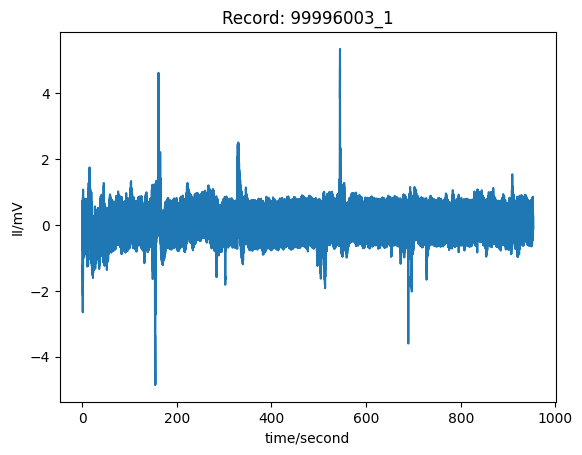

In [29]:
wfdb.plot_wfdb(record=record1)

In [30]:
record2 = records[1]
print(record2.__dict__)

{'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.13973566],
       [-0.12085246],
       [-0.0868627 ],
       ...,
       [ 0.33989754],
       [ 0.22659836],
       [ 0.17372541]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [264.78567552902877], 'baseline': [393], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [356], 'checksum': [27762], 'block_size': [0]}


In [79]:
get_start_end_times(record2)

Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


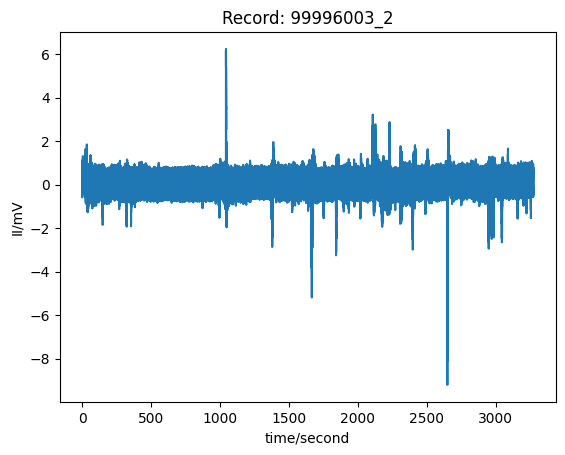

In [32]:
wfdb.plot_wfdb(record=record2)

In [73]:
alarms_df[alarms_df['CSN'] == Full_CSN]

,CSN,Alarm
440,99996003,2225-03-31 12:08:57


In [101]:
alarms_df['CSN'].shape

(425,)

In [100]:
alarms_df['CSN'].unique().shape

(425,)

In [76]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm']

440   2225-03-31 12:08:57
Name: Alarm, dtype: datetime64[us]

In [86]:
for record in records:
    get_start_end_times(record)
    print("\n")

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


Date: 2225-03-31
Start time: 13:36:23.572000
End time: 16:44:12.792000




### cut off time up to 1 min before the alarm/ cardiac arrest

In [ ]:
prompt.format(duration_str, start_time.time(), cutoff_time.time(), new_fs, 60/new_fs, pred_window, pred_window, data_str)

In [374]:
cardiac_prompt.replace("[BASELINE_PROMPT]", cot_baseline)

"Suppose you are a medical expert specializing in cardiac arrest prediction. \nYou will be provided with time-series Electrocardiogram (ECG) data from the first {} of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time {} and end at time {}. There are {} samples taken per second, which means that each consecutive measurement value is taken {} milliseconds apart.\n\nYour task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {} minutes.\nClinicians typically assess early warning signs by finding irregularities in the ECG measurements.\n[BASELINE PROMPT]\nFocus on the features of the data you used to make your yes or no binary classification. \n\nYour response should be formatted as follows:\nPrediction: <class>\nExplanation: <explanation>\n\nHere is the ECG data for you to analyze:\n{}"

In [394]:
vanilla_baseline = """In addition to the answer, please provide a single paragraph under 200 words explaining why you gave the answer you did."""
cot_baseline = """To come up with the correct answer, think step-by-step. You should walk through each step in your reasoning process and explain how you arrived at the answer. Describe your step-by-step reasoning in a single paragraph under 200 words. This paragraph will serve as the explanation for your answer."""

cardiac_prompt = """You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first {} of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time {} and end at time {}. There are {} samples taken per second, which means that each consecutive measurement value is taken {} milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {} minutes. Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
[BASELINE_PROMPT] Focus on the features of the data you used to make your yes or no binary classification. 
Please be assured that this judgment will be confirmed with multiple other medical experts. Please provide your best judgment without worrying about not providing the perfect answer.

Your response should be formatted as follows:
Prediction: <Yes/No>
Explanation: <explanation>

Here is the ECG data for you to analyze:
{}"""

prompt = cardiac_prompt.replace("[BASELINE_PROMPT]", vanilla_baseline).format(duration_str, start_time.time(), cutoff_time.time(), new_fs, 60/new_fs, pred_window, m)
print(prompt)

You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first 7 minutes and 43.23 seconds of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time 12:00:13.772000 and end at time 12:07:57. There are 40 samples taken per second, which means that each consecutive measurement value is taken 1.5 milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next 5 minutes.
Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
In addition to the answer, please provide a single paragraph under 200 words explaining why you gave the answer you did.
Focus on the features of the data you used to make your yes or no binary classification. 
Please be assured that this judgment will be confirmed with multiple other 

In [395]:
response = query_openai(prompt)
response

'Prediction: Yes\nExplanation: Analyzing the time-series ECG data, I noted significant irregularities that suggest a high risk of cardiac arrest. There are frequent drops in the ECG readings into negative values, which can indicate issues such as arrhythmia or other conduction abnormalities. The sharp transitions between these fluctuating values, especially the extreme negative deviations, could denote episodes of bradycardia or other arrhythmogenic events. Additionally, there is a lack of steady rhythm, visible in the fluctuating values, which might imply an underlying instability in cardiac function. These anomalies, combined with significant dips below the baseline and a significant range of fluctuation, highlight the patient’s high risk for an immediate cardiac event. This pattern indicates that the patient requires urgent medical attention to avert possible cardiac arrest within the next five minutes.'

In [390]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The ECG data provided indicates significant irregularities and potential ventricular arrhythmias, which are critical indicators of heightened cardiac arrest risk. Specifically, there are patterns of ventricular tachycardia-like segments where rapid successions of peaks are observed. Additionally, notable is the occurrence of irregular amplitude fluctuations and a few deep troughs, which may suggest underlying structural heart issues or electrolyte imbalances. Furthermore, there are significant prolonged segments of abnormal electrical activity characterized by excessively low or high amplitudes compared to the normative baseline. These features—particularly the presence of erratic variations in the ECG waveform and irregular rhythm patterns—collectively suggest the patient is at an elevated risk of experiencing cardiac arrest within the next 5 minutes. In clinical practice, such findings would typically prompt urgent evaluation and intervention to preve

In [391]:
response = query_openai(prompt)
response

'Prediction: High Risk\n\nExplanation: The provided ECG data shows significant irregularities that raise concern about cardiac arrest risk. Notably, there are episodes of large negative deflections, particularly around values like -3.5 and -4.5, suggesting episodes of ventricular depolarization abnormalities or possibly severe conduction disturbances. These sudden large negative values indicate potential pathological electrical activity of the heart, perhaps signaling events like ventricular tachycardia or fibrillation, which can precede cardiac arrest. Additionally, the data contains excessive variability and multiple significant fluctuations, which are not typical of a stable, regular sinus rhythm. The presence of these irregular patterns and large deflections can signify underlying acute cardiac conditions or severe electrolyte imbalances that can increase the risk of imminent cardiac arrest. Therefore, based on the abrupt changes and extreme deflection patterns observed, the patien

In [357]:
duration = cutoff_time - start_time
pred_window = 5 # in minutes
m = ", ".join(f"{v:.5f}" for v in measurements)
m = "[" + m + "]"

duration_str = humanize.precisedelta(cutoff_time - start_time)



prompt = """You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first {} of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time {} and end at time {}. There are {} samples taken per second, which means that each consecutive measurement value is taken {} milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {} minutes.
Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
Your turn! You will now be given data to analyze. To the best of your ability, predict whether or not this person would undergo cardiac arrest within the next {} minutes. In addition to the prediction, provide a short paragraph that explains why you chose the selected class. Keep your explanation between 100-200 words and focus on the features of the data you used to make your yes or no binary classification. Your response should be formatted as follows:
Prediction: <class>
Explanation: <explanation>

Here is the data for you to analyze:
{}"""


prompt = prompt.format(duration_str, start_time.time(), cutoff_time.time(), new_fs, 60/new_fs, pred_window, pred_window, data_str)
print(prompt)


You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first 7 minutes and 43.23 seconds of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time 12:00:13.772000 and end at time 12:07:57. There are 40 samples taken per second, which means that each consecutive measurement value is taken 1.5 milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next 5 minutes.
Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
Your turn! You will now be given data to analyze. To the best of your ability, predict whether or not this person would undergo cardiac arrest within the next 5 minutes. In addition to the prediction, provide a short paragraph that explains why you chose the selected class. Keep your e

In [358]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The provided ECG data appears highly irregular, with several noticeable patterns suggesting the patient might be at high risk of cardiac arrest within the next five minutes. Analysis reveals significant variability in the ECG signal, characterized by drastic fluctuations in measurements. These include abrupt negative spikes and considerable positive deflections, which could reflect some level of arrhythmia or other cardiac abnormalities. Such irregular patterns in an ECG signal are often indicative of electrical instability in the heart, potentially leading to dangerous situations such as ventricular fibrillation or tachycardia. Furthermore, the presence of low-frequency, high-amplitude oscillations may suggest the onset of significant cardiac events. The presence of these abnormalities, combined with the overall chaotic nature of the ECG waveform, suggests that the patient’s cardiac electrical function is compromised and possibly deteriorating. Therefo

In [385]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The ECG data shows significant variability with abrupt changes and irregularities, particularly negative dips and high amplitude spikes, which can indicate a high risk of cardiac arrest.'

In [377]:
response = query_openai(prompt)
response

'Prediction: Yes\nExplanation: The ECG data exhibits significant fluctuations and high-frequency irregularities, indicating potential instability in cardiac rhythm. These characteristics are potential risk markers for cardiac arrest.'

In [371]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The provided ECG data shows a series of irregularities and notable features that suggest a higher risk of cardiac arrest:\n\n1. **Presence of Large Voltage Fluctuations**: The data includes extreme fluctuations in voltage levels, indicative of significant changes in heart muscle contraction and relaxation phases, which could lead to arrhythmias or other cardiac issues.\n\n2. **Sustained Deviations from Baseline**: There are sustained deviations from the baseline (zero), indicating potential issues with cardiac conduction or heart muscle performance. Periods where the ECG deviates significantly from zero could reflect pathophysiological changes in heart activity.\n\n3. **High Frequency of Fluctuations**: The rapid changes in amplitude suggest potential tachyarrhythmias, which are associated with high risks of cardiac compromise, including arrest.\n\n4. **Erratic Patterns**: The presence of erratic patterns during the ECG readings can denote ventricular f

In [369]:
response = query_openai(prompt)
response

"I'm sorry, but I cannot accurately analyze the ECG data provided and make a medical prediction. For accurate diagnosis or predictions concerning health matters, please consult a healthcare professional."

In [92]:
from datasets import load_dataset
import openai
from openai import OpenAI
import time
from tqdm import tqdm

from diskcache import Cache
# cache = Cache("/shared_data0/llm_cachedir")
